# Preliminary EDA

In [1]:
# Suppress native-hadoop warning
!sed -i '$a\# Add the line for suppressing the NativeCodeLoader warning \nlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR,console' /$HADOOP_HOME/etc/hadoop/log4j.properties

In [2]:
import sys
sys.path.append('/home/work')
BASE_DIR = '/home/work'

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, count, desc, min, max, log, abs, mean, stddev
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data.utils.data_loader import load_file_from_hdfs

from EDA.clean_data import cleaned_df

In [4]:
conf = pyspark.SparkConf()
settings = conf.getAll()

# Set Spark Settings
conf = pyspark.SparkConf().setAll([
('spark.master', 'local[4]'),
('spark.app.name', 'MusicRecommender'),
('spark.driver.memory','14g')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Print the Spark Session settings
settings = spark.sparkContext.getConf().getAll()
for s in settings:
    print(s)

('spark.master', 'local[4]')
('spark.driver.port', '43923')
('spark.app.startTime', '1716969999726')
('spark.executor.id', 'driver')
('spark.driver.host', '6050231e74e3')
('spark.app.submitTime', '1716969999588')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=A

Load choosen partition of song ratings, song attributes, and genre hierarchy.

In [5]:
song_ratings_train_file_path = "/raw/train/train_2.txt"
song_ratings_train = load_file_from_hdfs(song_ratings_train_file_path)

song_ratings_test_file_path = "/raw/test/test_2.txt"
song_ratings_test = load_file_from_hdfs(song_ratings_test_file_path)

song_ratings = song_ratings_train.union(song_ratings_test)

song_attributes_file_path = "song-attributes.txt"
song_attributes = load_file_from_hdfs(song_attributes_file_path)

genre_hierarchy_file_path = "genre-hierarchy.txt"
genre_hierarchy = load_file_from_hdfs(genre_hierarchy_file_path)

Call cleaned_df function to get cleaned df from EDA

In [8]:
df = cleaned_df(song_ratings,song_attributes,genre_hierarchy)

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|summary|          genre_id|          song_id|           user_id|            rating|          album_id|         artist_id|       genre_name|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|  count|          78909821|         78909821|          78909821|          78909821|          78909821|          78909821|         78909821|
|   mean|16.666298850177345|68274.02707812504|499746.46840439545|3.1528440674070213|10361.592222392697|4776.0641216636395|             NULL|
| stddev| 42.91624825455018|39459.18779033151| 57936.75037674207|1.6030326088607252| 5906.090895444379| 2680.786813237493|             NULL|
|    min|                 0|                0|            400000|                 1|                 0|                 0|Adult Alternative|
|    max|    

In [9]:
df.count()

78909821

Get users' rating count to ensure balanced distribution of ratings per user.

In [10]:
user_ratings_count = df.groupBy("user_id").count()
user_ratings_count = user_ratings_count.withColumnRenamed("count", "ratings_count")
user_ratings_count.show()

+-------+-------------+
|user_id|ratings_count|
+-------+-------------+
| 400003|          266|
| 400129|           60|
| 400152|          108|
| 400301|          375|
| 400440|           36|
| 400612|           67|
| 400735|          312|
| 400797|          161|
| 400833|           69|
| 400982|          687|
| 401161|           38|
| 401778|           43|
| 401880|          403|
| 401901|          678|
| 402253|          161|
| 402643|         2183|
| 402896|          140|
| 403340|         7576|
| 403389|         1021|
| 403422|           33|
+-------+-------------+
only showing top 20 rows



Min and max values of users are quite different. There must be some outliers.

In [11]:
min_max_values = user_ratings_count.select(min("ratings_count").alias("min_value"), max("ratings_count").alias("max_value")).first()

min_value = min_max_values["min_value"]
max_value = min_max_values["max_value"]

print("Minimum value:", min_value)
print("Maximum value:", max_value)

Minimum value: 30
Maximum value: 131533


Distribution is extremely skewed.

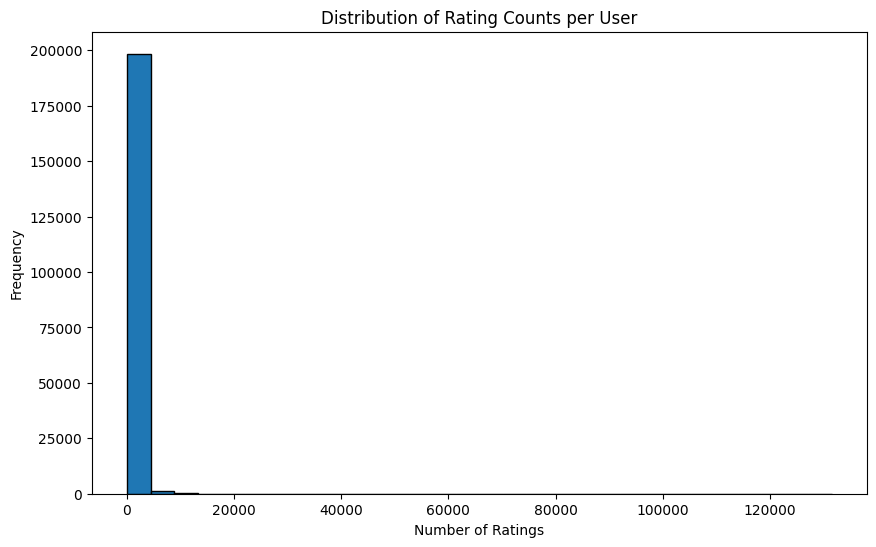

Total number of users: 200000


In [12]:
data= user_ratings_count.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(data['ratings_count'], bins=30, edgecolor='black')
plt.title('Distribution of Rating Counts per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

total_users = user_ratings_count.count()
print("Total number of users:", total_users)

In [13]:
user_ratings_count[user_ratings_count['ratings_count'] == 0].count() # no zero
user_ratings_count = user_ratings_count.withColumn('log_ratings_count', log(user_ratings_count['ratings_count']))  

In [15]:
mean_log = user_ratings_count.select(mean(col("log_ratings_count"))).collect()[0][0]
stddev_log = user_ratings_count.select(stddev(col("log_ratings_count"))).collect()[0][0]

user_ratings_count = user_ratings_count.withColumn("z_score", (col("log_ratings_count") - mean_log) / stddev_log)
user_ratings_count = user_ratings_count.withColumn("is_outlier", abs(col("z_score")) > 3) # threshold 3

In [16]:
user_ratings_count_cleaned = user_ratings_count.filter(col("is_outlier") == False)
print("Original DataFrame:", user_ratings_count.count())
print("Cleaned DataFrame (without outliers):", user_ratings_count_cleaned.count())

Original DataFrame: 200000


Cleaned DataFrame (without outliers): 199351


Still extremely skewed with large range of ratings count.

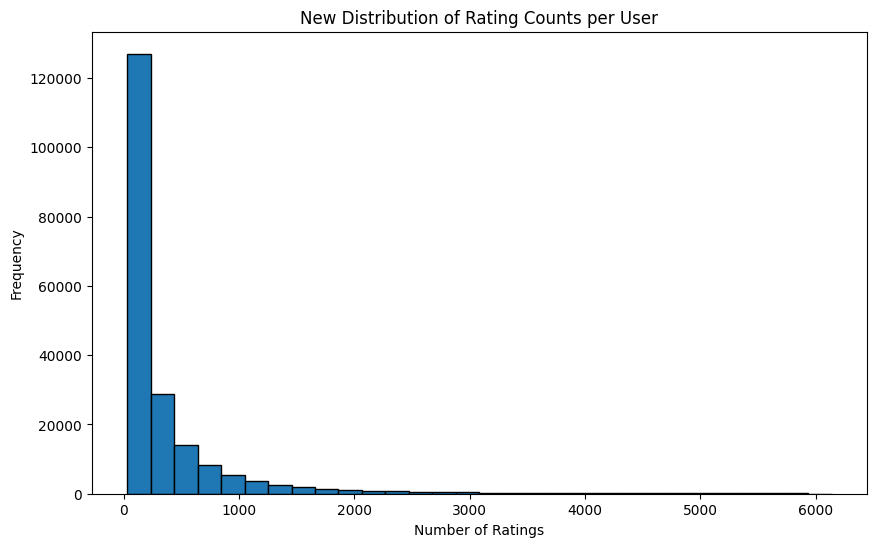

In [17]:
user_ratings_count_cleaned_data= user_ratings_count_cleaned.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(user_ratings_count_cleaned_data['ratings_count'], bins=30, edgecolor='black')
plt.title('New Distribution of Rating Counts per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

In [18]:
#user_ratings_count_cleaned_df = df.join(user_ratings_count_cleaned.select("user_id"), on="user_id", how="inner")
#user_ratings_count_cleaned_df.show()

+-------+--------+-------+------+--------+---------+-----------+
|user_id|genre_id|song_id|rating|album_id|artist_id| genre_name|
+-------+--------+-------+------+--------+---------+-----------+
| 400003|       0|    909|     5|   12325|     7868|    Unknown|
| 400003|       0|   1078|     4|   15269|      443|    Unknown|
| 400003|       0|   1244|     4|    4257|     6918|    Unknown|
| 400003|       0|   3245|     3|   14647|     8510|    Unknown|
| 400003|       0|   3378|     4|    1574|     1926|    Unknown|
| 400003|       0|   5279|     5|   12268|     8543|    Unknown|
| 400003|       0|   5448|     4|   12886|     7092|    Unknown|
| 400003|       0|   7351|     4|    3442|     7254|    Unknown|
| 400003|       0|   7475|     5|   18801|     5187|    Unknown|
| 400003|     106|   9802|     3|    2136|     2640|        Pop|
| 400003|       0|  11832|     5|   16836|     3279|    Unknown|
| 400003|       0|  12383|     4|   10938|     9123|    Unknown|
| 400003|       0|  13370

In [19]:
user_ratings_count_cleaned_df.count()

72806352

Use IQR, lower bound, upper bound to remove outliers

In [20]:
quantiles = user_ratings_count.approxQuantile("ratings_count", [0.25, 0.75], 0.05)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

filtered_df = user_ratings_count.filter((col("ratings_count") >= lower_bound) & (col("ratings_count") <= upper_bound))

print("Data count without Outliers:", filtered_df.count())

Data count without Outliers: 173463


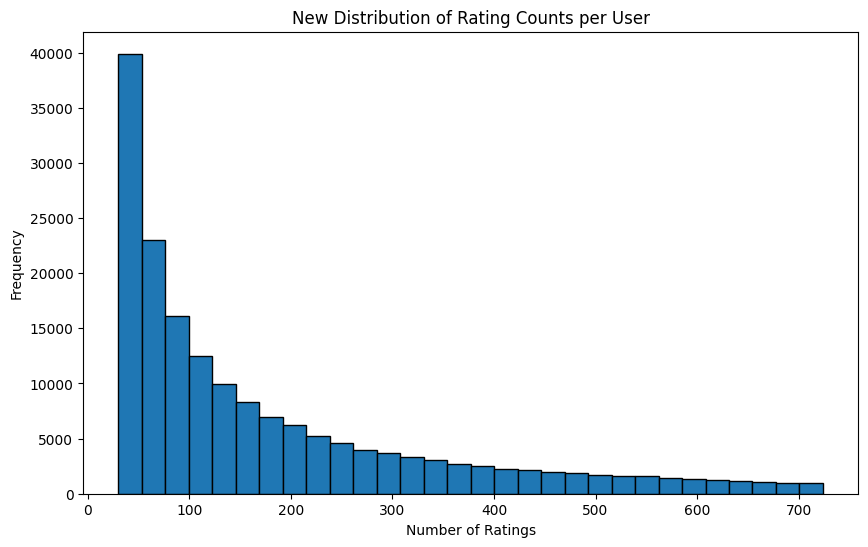

In [21]:
filtered_df_data= filtered_df.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(filtered_df_data['ratings_count'], bins=30, edgecolor='black')
plt.title('New Distribution of Rating Counts per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

In [22]:
filtered_df_new = df.join(filtered_df.select("user_id"), on="user_id", how="inner")
print("new dataset count", filtered_df_new.count())

new dataset count 31116051


In [23]:
train_df, test_df = filtered_df_new.randomSplit([0.8, 0.2], seed=42)

In [24]:
train_df.show()

+-------+--------+-------+------+--------+---------+----------+
|user_id|genre_id|song_id|rating|album_id|artist_id|genre_name|
+-------+--------+-------+------+--------+---------+----------+
| 400001|       0|  18663|     4|    8240|     3065|   Unknown|
| 400001|       0|  18936|     5|   10268|     5068|   Unknown|
| 400001|       0|  35799|     5|    6455|     1926|   Unknown|
| 400001|       0|  38174|     5|    6455|     1926|   Unknown|
| 400001|       0|  39919|     5|   16811|     2105|   Unknown|
| 400001|       0|  44760|     4|   17346|     2939|   Unknown|
| 400001|       0|  56660|     4|   11718|     3667|   Unknown|
| 400001|       0|  59796|     5|    3298|     2956|   Unknown|
| 400001|       0|  66132|     5|    5618|     8444|   Unknown|
| 400001|       0|  83028|     5|    7194|     7676|   Unknown|
| 400001|       0|  90136|     4|    6176|     3371|   Unknown|
| 400001|       0|  94003|     4|    4661|     8187|   Unknown|
| 400001|       0|  94466|     4|   1071

In [25]:
test_df.show()

+-------+--------+-------+------+--------+---------+----------+
|user_id|genre_id|song_id|rating|album_id|artist_id|genre_name|
+-------+--------+-------+------+--------+---------+----------+
| 400001|       0|  30670|     4|    6695|     9367|   Unknown|
| 400001|       0|  41073|     4|    3334|      868|   Unknown|
| 400001|       0|  53890|     4|   16454|     8444|   Unknown|
| 400001|       0|  84589|     5|    8179|     8444|   Unknown|
| 400001|       0| 105698|     5|   15941|     5958|   Unknown|
| 400001|       0| 125173|     5|   19094|       69|   Unknown|
| 400001|     134|  18878|     5|   12051|     8021|      Rock|
| 400002|       0|   3250|     5|   11469|     1288|   Unknown|
| 400002|       0|  16794|     5|    2517|     7620|   Unknown|
| 400002|       0|  17312|     5|   12410|     1992|   Unknown|
| 400002|       0|  18799|     5|    3125|     7303|   Unknown|
| 400002|       0|  19538|     5|   14785|      772|   Unknown|
| 400002|       0|  22358|     2|    583